<a href="https://colab.research.google.com/github/angel870326/Hierarchical-Clustering/blob/main/taipei_pca_hierarchical_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 2022.04.22 Ssu-Yun Wang<br/>
[Github @angel870326](https://github.com/angel870326)

#**Hierarchical Clustering & Dimensionality Reduction (Taipei)**

This is an example of hierarchical clustering for ***text data with missing values*** by using the clustering package [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html). 

The dataset I used do not need the process of stopwords removing, stemming or tokenization. It is quite similar to categorial data but with text instead of label in each cell. Therefore, each observation can be regarded as a document, and each column (except for ID) can be regarded as a feature for the observation. You will see how to deal with missing values and **reduce dimensions using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)** in section 1.2. We can transfer each observation into an tf-idf vector and calculate cosine similarities between observations just like what we do in document clustering. 

In section 1.4 and 1.5, you will see four kinds of clustering method, including single-link, complete-link, group average and Ward algorithm, and how to generate clustering results with a threshold. 

<br/>

####**Contents:**

1.1 Read file<br/>
1.2 Data preprocessing<br/>
1.3 Cosine similarity & distance<br/>
1.4 Hierarchical clustering<br/>
1.5 Set a threshold<br/>
1.6 Save the results<br/>

<br/>

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [2]:
# sConnect to the Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##**1. Text Clustering**

###**1.1 Read file**


---



In [17]:
data = pd.read_csv('/content/gdrive/Shareddrives/110-2 Capstone/最終資料檔/雙北/building_taipei.csv')

# Number of observations and variables
print(data.shape)
# Overview dataset
data.describe()

(5554, 12)


,c0101,c0114,c0129,c0162,age_Category,c0121_Category,c0118_new,c0179_new,c0123_new,c0122_new,c0158_new,area
count,5554,4418,5073,5554,5554,5554,4472,5554,4035,5554,5554,5554
unique,5554,37,4,2,9,4,3,2,3,2,2,12
top,0000251,南,24小時,重點,十一年至十五年屋齡,極少戶數,大公設比,近一年有實價登錄,臨單線道,有平面車位,無機械車位,大安區
freq,1,1015,2977,3363,917,3204,1702,2933,2819,2949,4278,881


###**1.2 Data preprocessing**


---



####***1.2.1 Concatenate cells(features) into a string with separator (ignore NA)***




In [18]:
df = pd.DataFrame(data.c0101)
df['content'] = data.iloc[:,1:-1].apply(lambda x: ','.join(x.dropna().values.tolist()), axis=1)
labels = np.array(df['c0101'])
df

,c0101,content
0,0000251,"東,24小時,重點,三十一年至三十五年屋齡,極多戶數,小公設比,近一年有實價登錄,臨單線道,..."
1,0000252,"南,24小時,重點,二十六年至三十年屋齡,少戶數,中公設比,近一年有實價登錄,臨單線道,有平..."
2,0000253,"日間管理,一般,二十六年至三十年屋齡,少戶數,大公設比,近一年有實價登錄,臨單線道,有平面車..."
3,0000254,"南,24小時,重點,二十六年至三十年屋齡,多戶數,中公設比,近一年有實價登錄,臨單線道,有平..."
4,0000260,"東,日間管理,一般,二十六年至三十年屋齡,極少戶數,近一年無實價登錄,臨單線道,有平面車位,..."
...,...,...
5549,Y001263,"西北,無管理,重點,十一年至十五年屋齡,極少戶數,大公設比,近一年無實價登錄,臨單線道,有平..."
5550,Y001264,"東,東北,24小時,重點,十一年至十五年屋齡,多戶數,大公設比,近一年有實價登錄,臨單線道,..."
5551,Y001265,"南,24小時,重點,十一年至十五年屋齡,少戶數,中公設比,近一年有實價登錄,臨多線道,有平面..."
5552,Y001273,"西,24小時,重點,十一年至十五年屋齡,極少戶數,大公設比,近一年無實價登錄,有平面車位,無..."


####***1.2.2 Tf-idf vectorizer***


In [19]:
# text contents in dataframe to array
contents = np.array(df['content']) 
contents

# tfidf vectorizer
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b') 
tfidf_matrix = vectorizer.fit_transform(contents)
tfidf_matrix

# See the first vector (optional)
first_vector = tfidf_matrix[0]
first_dict = pd.DataFrame(first_vector.T.todense(), index = vectorizer.get_feature_names_out(), columns = ["tfidf"])

# See all terms
terms = vectorizer.get_feature_names_out()
print("Terms: ",terms) # 台北市沒有夜間管理

# Store vectorized texts in df
df['tfidf'] = list(tfidf_matrix.toarray())
df

Terms:  ['24小時' '一般' '三十一年至三十五年屋齡' '三十六年至四十年屋齡' '中公設比' '二十ㄧ年至二十五年屋齡' '二十六年至三十年屋齡'
 '五年內屋齡' '六年至十年屋齡' '其他管理形式' '北' '十一年至十五年屋齡' '十六年至二十年屋齡' '南' '四十年以上屋齡'
 '多戶數' '多方位' '大公設比' '小公設比' '少戶數' '日間管理' '有平面車位' '有機械車位' '東' '東北' '東南'
 '極多戶數' '極少戶數' '無平面車位' '無機械車位' '無管理' '臨單線道' '臨多線道' '臨雙線道' '西' '西北' '西南'
 '近一年有實價登錄' '近一年無實價登錄' '重點']


,c0101,content,tfidf
0,0000251,"東,24小時,重點,三十一年至三十五年屋齡,極多戶數,小公設比,近一年有實價登錄,臨單線道,...","[0.20543258198430686, 0.0, 0.439331574195482, ..."
1,0000252,"南,24小時,重點,二十六年至三十年屋齡,少戶數,中公設比,近一年有實價登錄,臨單線道,有平...","[0.2555459672798244, 0.0, 0.0, 0.0, 0.36861481..."
2,0000253,"日間管理,一般,二十六年至三十年屋齡,少戶數,大公設比,近一年有實價登錄,臨單線道,有平面車...","[0.0, 0.3076133515793043, 0.0, 0.0, 0.0, 0.0, ..."
3,0000254,"南,24小時,重點,二十六年至三十年屋齡,多戶數,中公設比,近一年有實價登錄,臨單線道,有平...","[0.2263930035351384, 0.0, 0.0, 0.0, 0.32656283..."
4,0000260,"東,日間管理,一般,二十六年至三十年屋齡,極少戶數,近一年無實價登錄,臨單線道,有平面車位,...","[0.0, 0.29548536930373753, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...
5549,Y001263,"西北,無管理,重點,十一年至十五年屋齡,極少戶數,大公設比,近一年無實價登錄,臨單線道,有平...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5550,Y001264,"東,東北,24小時,重點,十一年至十五年屋齡,多戶數,大公設比,近一年有實價登錄,臨單線道,...","[0.19391904195114185, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5551,Y001265,"南,24小時,重點,十一年至十五年屋齡,少戶數,中公設比,近一年有實價登錄,臨多線道,有平面...","[0.24200769250060306, 0.0, 0.0, 0.0, 0.3490863..."
5552,Y001273,"西,24小時,重點,十一年至十五年屋齡,極少戶數,大公設比,近一年無實價登錄,有平面車位,無...","[0.2665929601642648, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


####***1.2.3 Dimensionality reduction by PCA***
Source: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(tfidf_matrix.toarray())

from sklearn.decomposition import PCA
pca = PCA().fit(data_rescaled)

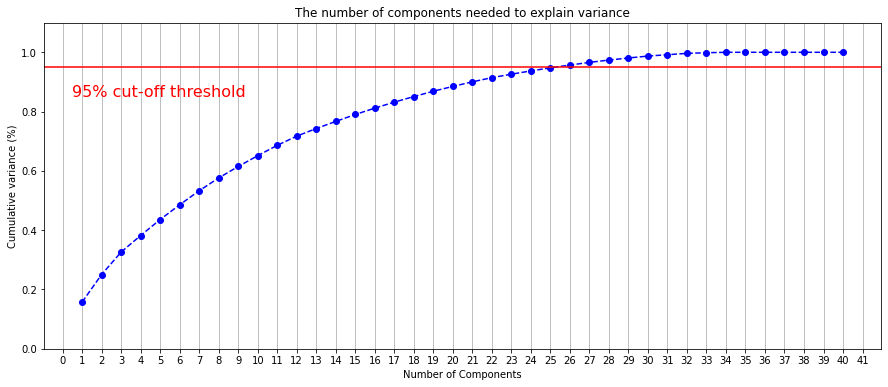

In [9]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)

fig, ax = plt.subplots()
xi = np.arange(1, 41, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 42, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [10]:
pca = PCA(n_components=33) 
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

###**1.3 Cosine similarity & distance**


---


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
# dist = 1 - cosine_similarity(tfidf_matrix)
dist = 1 - cosine_similarity(tfidf_pca)
print

<function print>

###**1.4 Hierarchical clustering**


---


In [12]:
from scipy.cluster.hierarchy import fcluster, single, complete, average, ward, dendrogram

####***1.4.1 Single-Link***

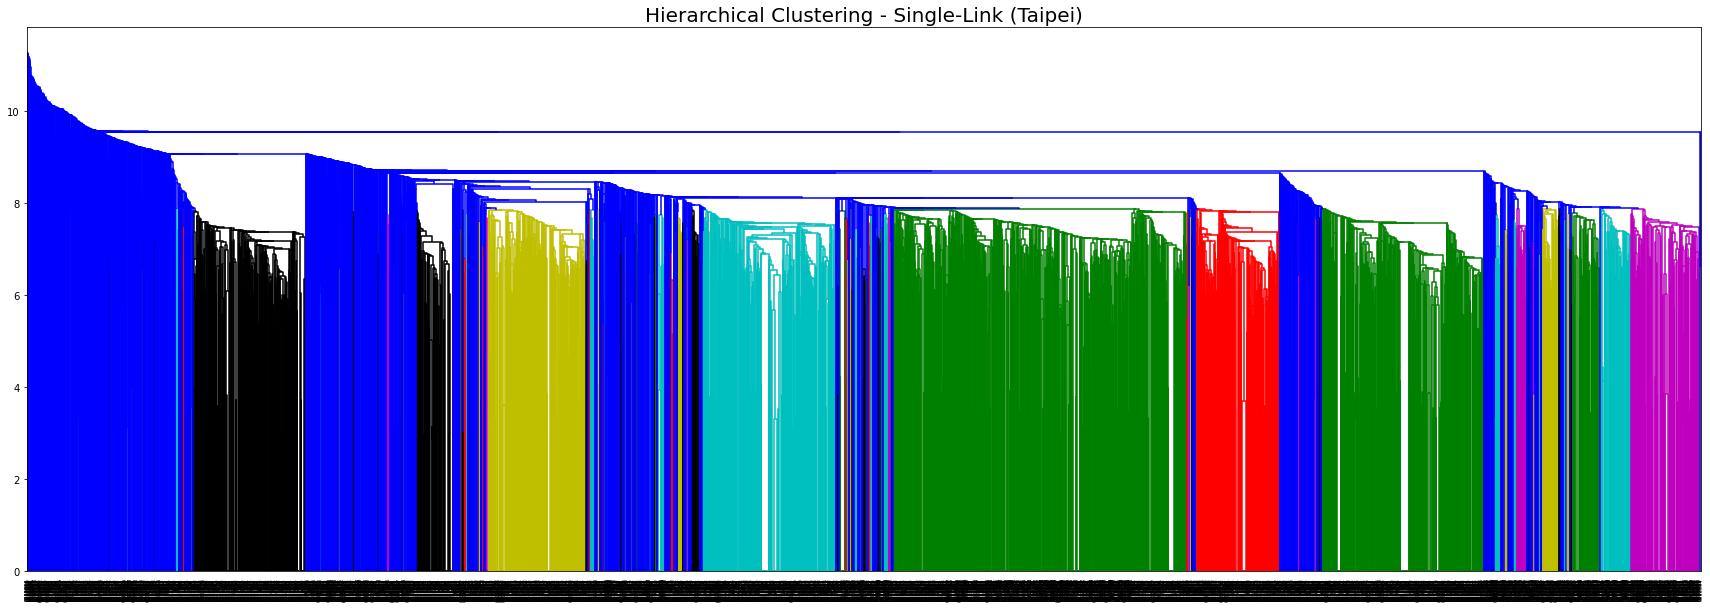

In [13]:
linkage_matrix_single = single(dist)

# plot
plt.subplots(figsize=(30, 10))  # set size
plt.title('Hierarchical Clustering - Single-Link (Taipei)', fontsize=20)
dn_single = dendrogram(linkage_matrix_single, labels=labels);

####***1.4.2 Complete-Link***


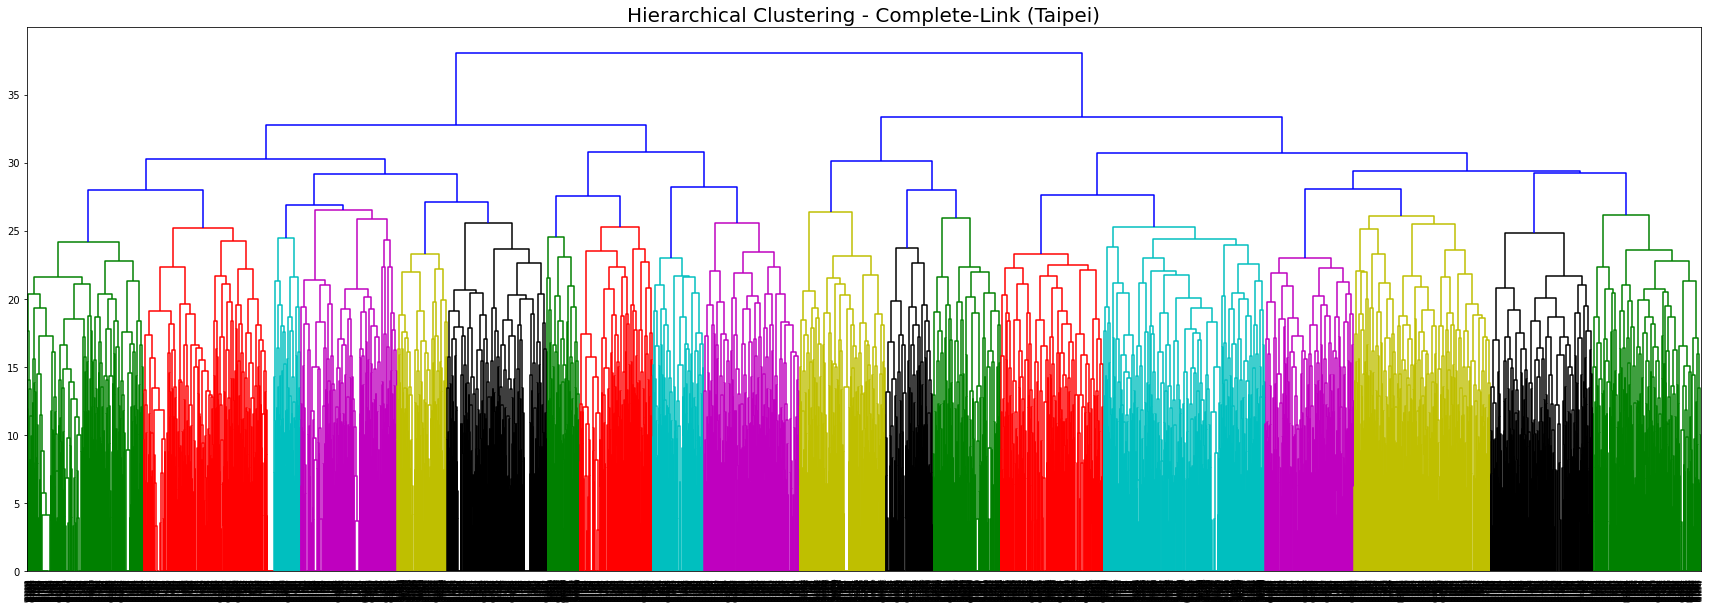

In [14]:
linkage_matrix_complete = complete(dist)

# plot
plt.subplots(figsize=(30, 10)) # set size
plt.title('Hierarchical Clustering - Complete-Link (Taipei)', fontsize=20)
dn_complete = dendrogram(linkage_matrix_complete, labels=labels)

####***1.4.3 Group Average***


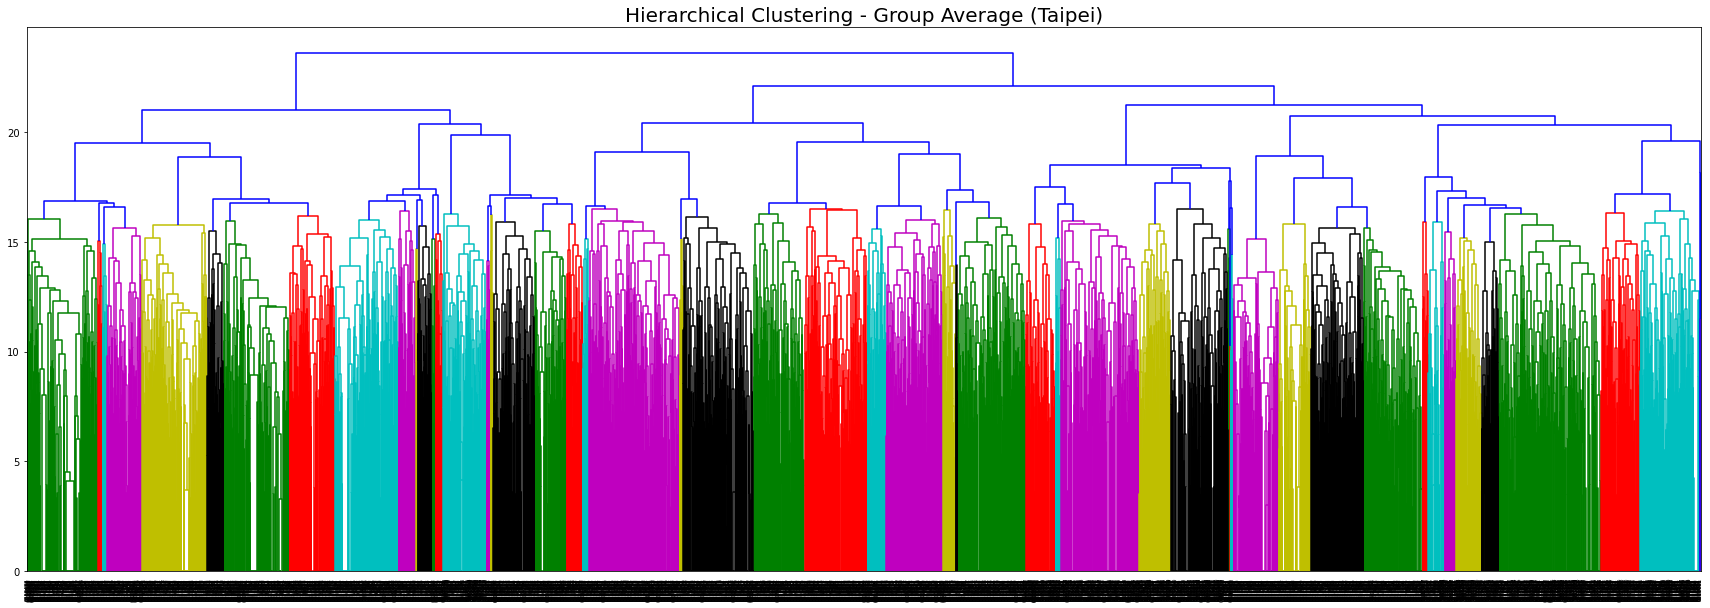

In [15]:
linkage_matrix_avg = average(dist)

# plot
plt.subplots(figsize=(30, 10)) # set size
plt.title('Hierarchical Clustering - Group Average (Taipei)', fontsize=20)
dn_avg = dendrogram(linkage_matrix_avg, labels=labels);

####***1.4.4 Ward***


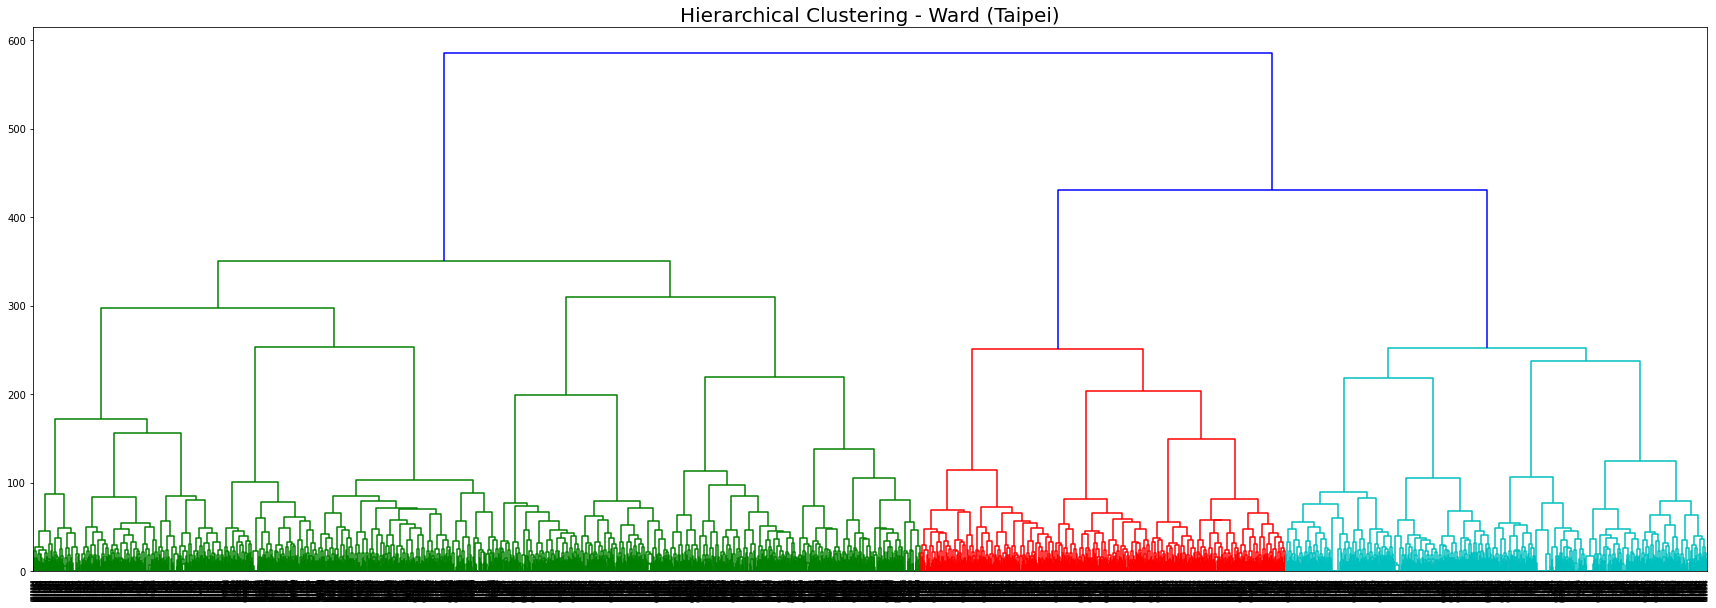

In [16]:
linkage_matrix_ward = ward(dist) 

# plot
plt.subplots(figsize=(30, 10)) # set size
plt.title('Hierarchical Clustering - Ward (Taipei)', fontsize=20)
dn_ward = dendrogram(linkage_matrix_ward, labels=labels);

###**1.5 Set a threshold**


In [20]:
# Set a threshold
k1 = 3
k2 = 4

# Single-link
# cluster_single = fcluster(linkage_matrix_single,k,criterion='maxclust')
# df['cluster_single'] = cluster_single

# Complete-link
cluster_complete_3 = fcluster(linkage_matrix_complete,k1,criterion='maxclust')
data['cluster_complete_3'] = cluster_complete_3
df['cluster_complete_3'] = cluster_complete_3
cluster_complete_4 = fcluster(linkage_matrix_complete,k2,criterion='maxclust')
data['cluster_complete_4'] = cluster_complete_4
df['cluster_complete_4'] = cluster_complete_4

# Group-average
cluster_avg_3 = fcluster(linkage_matrix_avg,k1,criterion='maxclust')
data['cluster_avg_3'] = cluster_avg_3
df['cluster_avg_3'] = cluster_avg_3
cluster_avg_4 = fcluster(linkage_matrix_avg,k2,criterion='maxclust')
data['cluster_avg_4'] = cluster_avg_4
df['cluster_avg_4'] = cluster_avg_4

# Ward
cluster_ward_3 = fcluster(linkage_matrix_ward,k1,criterion='maxclust')
data['cluster_ward_3'] = cluster_ward_3
df['cluster_ward_3'] = cluster_ward_3
cluster_ward_4 = fcluster(linkage_matrix_ward,k2,criterion='maxclust')
data['cluster_ward_4'] = cluster_ward_4
df['cluster_ward_4'] = cluster_ward_4


###**1.6 Save the results**

In [21]:
data.to_csv("/content/gdrive/My Drive/碩一下/Capstone/hierarchical_clustering/taipei/hierarchical_textcluster_pca_taipei.csv", index=False)
df.to_csv("/content/gdrive/My Drive/碩一下/Capstone/hierarchical_clustering/taipei/hierarchical_textcluster_pca_taipei_r.csv", index=False)